# PyTorch Transfer Learning

What is transfer learning?

Transfer learning involves taking the parameters of what one model has learned on another data and applying to our own problem.

* Pretrained model == foundation model

In [2]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


Now we've got the versions of torch and torchvision, we're after, let's import the code written in previous sections so that we don't have to write it all again.

In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 29.41 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Get data

We need our pizza, steak, sushi data to build a transfer model on.

In [5]:
import os
import zipfile

from pathlib import Path

import requests

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # images from a subset of classes from  Fodd101 dataset

# If the image folder doesn't exists, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists, skipping re-download.")
else:
    print(f"Did not find{image_path}, downloading it...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, stake, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not finddata/pizza_steak_sushi, downloading it...
Unzipping pizza, steak, sushi data...


In [6]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

Now we've got some data, want to turn it into PyTorch DataLoaders.

To do so, we can use `data_setup.py` and the `create_dataloaders()` function.

There's on thing we have to think about when loading, how to **transform** it?

And with `torchvision` 0.13+ there's two ways to do this:

1. Manually created transforms -  you define what transforms you want your data tot go through.
2. Automatically created transforms - the transforms for your data are defined by the model you'd like to use.

Important point: when using a pretrained model, it's important that the data (including you custom data) that you pass through it is **transformed** in the same way that the data the model was trained on.

### 2.1 Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right within torchvision.

In [7]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],  # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                                 std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),

manual_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)), # resize image to 224, 224
    transforms.ToTensor(), # get images into rande [0, 1]
    normalize # make sure images have the same districution as ImageNet (where our pretrained models have been trained)
])

In [8]:
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c1d157ff880>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

As of `torchvision` v0.13+ there is now support for automatic data trasnform creation based on the pretrained model weights you're using.

In [9]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" - best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [10]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [11]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c1d157feb00>,
 ['pizza', 'steak', 'sushi'])

## 3. Gettting a pretrained model

There are various places to get a pretrained model, such as:
1. PyTorch domain libraries
2. Libraries like `timm` (torch image models)
3. HugginFace Hub (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)


### 3.1 Which pretrained model should you use?

*Experiment, experiment, experiment*

The while idea of transfer learning: take an already well-performing model from a problem space similar to your own and then customize to your own problem.

Three things to consider:
1. Speed - how fast does it need to run?
2. Size - how big is the model?
3. Performance - how well does it go on your chosen problem (e.g. how well does it classify food images? for FoodVision Mini)?

Where does the model live?

Is it on device? (like a self-driving car)

Or does it live on a server?

Looking at https://pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights

Which model should we choose?

For our case (deploying FoodVision Mini on a mobile device), it looks like EffNetB0 is oone of our best options in terms performance vs size.

However, in light of `The Bitter Lesson`, if we had infinite compute, we'd likely pick the biggest model + most parameters + most general we could.



### 3.2 Setting up a pretrained model

Want to creae an instance of EffNetB0.

In [12]:
# Old method of creating a pretrained model (prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True)

# new method of creating pretrained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # 'DEFAULT' - best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 140MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [13]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [14]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [15]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with torchinfo.summar()

In [16]:
# Print the torchinfo summary
from torchinfo import summary

def get_summary(model: torch.nn.Module):
    return summary(model=model,
            input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
            col_names=["input_size", "output_size", "num_params", "trainable"],
            row_settings=["var_names"])

get_summary(model)

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 1000]                 --                        True
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         864                       True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         64                        True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --                

### 3.4 Freezinf the base model and chaning the output layer to suit our needs

With a feature extractor model, typically you will "freeze" the base layers of a pretrained/foundation model and update the output layers to suit your own problem.

In [17]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
    param.requires_grad = False

In [18]:
get_summary(model)

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 1000]                 --                        Partial
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --         

In [19]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, # feature vector coming in
              out_features=len(class_names))
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [20]:
get_summary(model)

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 3]                    --                        Partial
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --         

## 4. Let's train the model

In [21]:
# Define loss and optimizer
import torch
from torch import nn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

loss_fn, optimizer

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [22]:
# Import train function from going modular
from going_modular.going_modular import engine

# Set the manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epocsh
NUM_EPOCHS = 10

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup the training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       epochs=NUM_EPOCHS,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
Epoch: 6 | train_loss: 0.5785 | train_acc: 0.8945 | test_loss: 0.5743 | test_acc: 0.8759
Epoch: 7 | train_loss: 0.5263 | train_acc: 0.9102 | test_loss: 0.5470 | test_acc: 0.8759
Epoch: 8 | train_loss: 0.5226 | train_acc: 0.8008 | test_loss: 0.5291 | test_acc: 0.8665
Epoch: 9 | train_loss: 0.5671 | train_acc: 0.8125 | test_loss: 0.5076 | test_acc: 0.8456
Epoch: 10 | train_loss: 0.4847 | train_acc: 0.8203 | test_loss: 0.4400 | test_acc: 0.9062
[INFO] Total training time: 34.454148 seconds


In [23]:
from pprint import pprint

pprint(results)

{'test_acc': [0.5397727272727273,
              0.8153409090909092,
              0.8560606060606061,
              0.8655303030303031,
              0.8560606060606061,
              0.8759469696969697,
              0.8759469696969697,
              0.8664772727272728,
              0.8456439393939394,
              0.90625],
 'test_loss': [0.9132681290308634,
               0.7911976178487142,
               0.7463406324386597,
               0.6373109420140585,
               0.6261006395022074,
               0.5743226806322733,
               0.5469824274381002,
               0.5290800531705221,
               0.5076459646224976,
               0.43997156620025635],
 'train_acc': [0.3984375,
               0.77734375,
               0.79296875,
               0.75390625,
               0.78515625,
               0.89453125,
               0.91015625,
               0.80078125,
               0.8125,
               0.8203125],
 'train_loss': [1.0924270078539848,
                0

## 5. Evaluate model by plotting loss curves

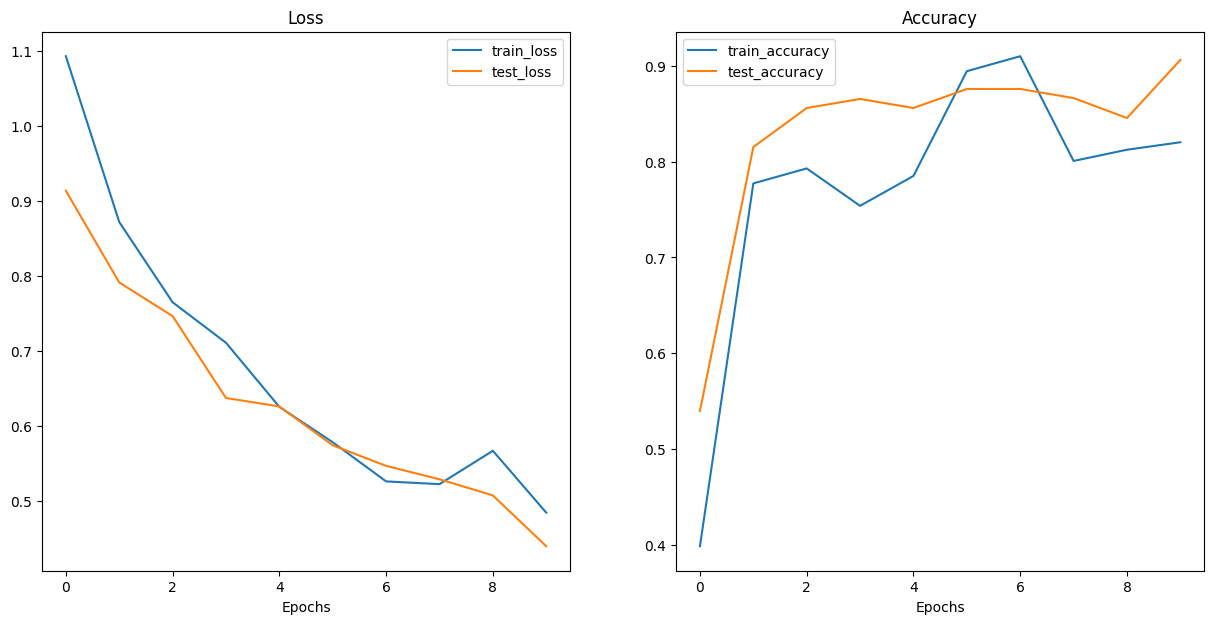

In [24]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_function.py, downloading it...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)

    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## 6. Make predictions on images from the test set

Let's adhere to the data explorer's motto of **visualize, visualize, visualize**!

And make some qualitative predictions on our test set.

Some things to keep in mind when making predictions/inference on test data/custom data.

We have to make sure that our test/custom data is:
* Same shape - images need to be same shape as model was trained on
* Same datatype - custom data should be in the same data type
* Same device - custom data/test data should be on the same device as the model
* Same transform - if you've transformed your custom data, ideally you will transform the test data and custom data the same

To do all of this automagically, let's create a function called `pred_and_plot_image()`.

1. Take in a trained model, a list of class names, a file path to a target image, an image size, a transform, and a target device
2. Open the image with `PIL.Image.Open()`
3. Create a transform if one doesn't exists
4. Make sure model is on the target device
5. Turn the model to `model.eval()` mode to make sure it's ready for inference (this will turn off things like `nn.Dropout()`)
6. Transform the target image and make sure its dimentionality is suited for the model (this makinly related to batch size)
7. Make a prediction on the image by passing to the model
8. Convert the model's output logits to prediction probabilities using `torch.softmaxn()`
9. Convert model's prediction probabilities to prediction labels using `torch.argmax()`
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8

In [ ]:
from typing import List, Tuple

from PIL import Image
from torchvision import transforms

def pred_and_plot_image(model: torch.nn.Module,
                        class_names: List[str],
                        image_path: str,
                        image_size: Tuple[int, int]=(224, 224),
                        transform: torchvision.transforms=None,
                        actual_label: str=None,
                        device: torch.device=device):
    """Method to predict the label from the given model and plot the image along with its actual and predicted value"""
    # Load the image using PIL
    image = Image.open(image_path)

    # Create the transform if not already present
    if transform is not None:
        image_transform = transform
    if transform is None:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    # Put the model into the target device
    model.to(device)

    # Make sure model is in eval mode
    model.eval()

    # Make a prediction
    with torch.inference_mode():
        # Transform the image
        image_tensor_transformed = image_transform(image).unsqueeze(dim=0)

        # Make the prediction
        prediction = model(image_tensor_transformed.to(device))

    # Turn logits to the prediction probabilities
    pred_prob = torch.softmax(prediction, dim=1)

    # Turn prediction probabilites into label
    pred_label = torch.argmax(pred_prob, dim=1)

    # Create the plot
    plt.figure()
    plt.imshow(image)
    plt.axis(False)
    if actual_label is not None:
        title = f"Pred: {class_names[pred_label.cpu()]} | Prob: {pred_prob.max():.3f} | Actual: {actual_label}"
    else:
        title = f"Pred: {class_names[pred_label.cpu()]} | Prob: {pred_prob.max():.3f}"
    plt.title(title)

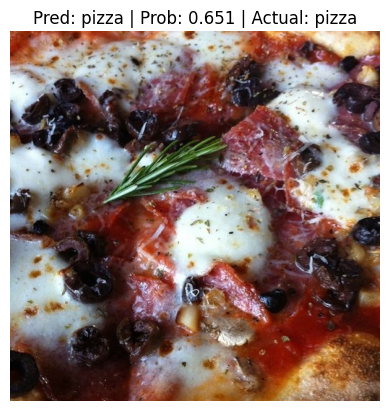

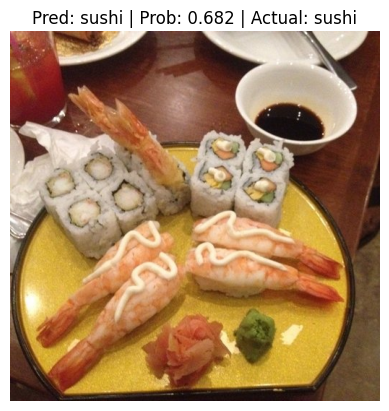

In [ ]:
# Get a random list of image paths from the test set
import random

num_images_to_plot = 2
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

for image_path in test_image_path_sample:
    actual_label = str(image_path).split("/")[-2]
    pred_and_plot_image(model=model,
                        class_names=class_names,
                        image_path=image_path,
                        image_size=(224, 224),
                        # transform=weights.transforms(),
                        actual_label=actual_label,
                        device=device)

### 6.1 Making prediction on custom image

data/04-pizza-dad.jpeg already exists, skipping download.


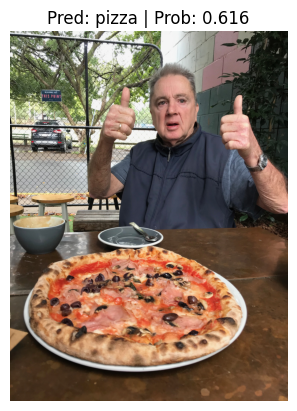

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)